In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os 
os.chdir('D:/')
import warnings
warnings.filterwarnings('ignore')
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

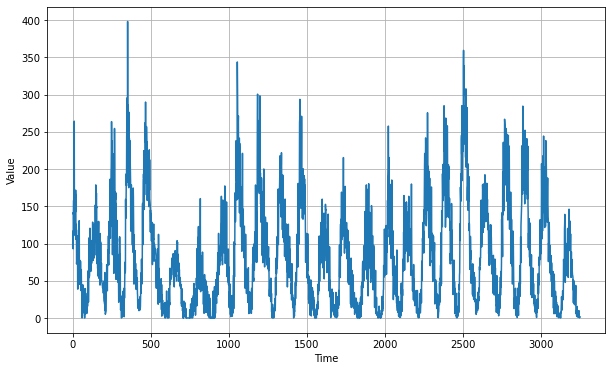

In [8]:
import csv
time_step = []
sunspots = []

with open('D:/Sohum/Sunspot.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8)#, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 604ms/step - loss: 80.5387 - mae: 80.5758
Epoch 2/100
12/12 [==============================] - 1s 44ms/step - loss: 80.0256 - mae: 80.3158
Epoch 3/100
12/12 [==============================] - 1s 45ms/step - loss: 79.8059 - mae: 80.0238
Epoch 4/100
12/12 [==============================] - 1s 45ms/step - loss: 79.2755 - mae: 79.6945
Epoch 5/100
12/12 [==============================] - 1s 87ms/step - loss: 79.1778 - mae: 79.3174
Epoch 6/100
12/12 [==============================] - 1s 45ms/step - loss: 78.7247 - mae: 78.8797
Epoch 7/100
12/12 [==============================] - 1s 45ms/step - loss: 78.3692 - mae: 78.3873
Epoch 8/100
12/12 [==============================] - 1s 46ms/step - loss: 77.2750 - mae: 77.8264
Epoch 9/100
12/12 [==============================] - 1s 46ms/step - loss: 77.1699 - mae: 77.1958
Epoch 10/100
12/12 [====

Epoch 83/100
12/12 [==============================] - 1s 47ms/step - loss: 32.8914 - mae: 33.3941
Epoch 84/100
12/12 [==============================] - 1s 94ms/step - loss: 34.2123 - mae: 34.5893
Epoch 85/100
12/12 [==============================] - 1s 45ms/step - loss: 35.0986 - mae: 35.3288
Epoch 86/100
12/12 [==============================] - 1s 50ms/step - loss: 34.6392 - mae: 35.2650
Epoch 87/100
12/12 [==============================] - 1s 76ms/step - loss: 34.8860 - mae: 34.9869
Epoch 88/100
12/12 [==============================] - 1s 45ms/step - loss: 39.8887 - mae: 40.9586
Epoch 89/100
12/12 [==============================] - 1s 46ms/step - loss: 35.8415 - mae: 35.6382
Epoch 90/100
12/12 [==============================] - 1s 47ms/step - loss: 43.7658 - mae: 44.2722
Epoch 91/100
12/12 [==============================] - 1s 50ms/step - loss: 40.6919 - mae: 40.7709
Epoch 92/100
12/12 [==============================] - 1s 56ms/step - loss: 49.3166 - mae: 49.4674
Epoch 93/100
12/12 [

(1e-08, 0.0001, 0.0, 60.0)

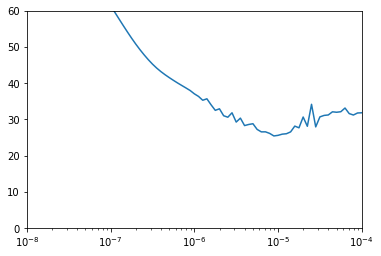

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 117ms/step - loss: 37.8971 - mae: 38.6063
Epoch 2/500
30/30 [==============================] - 1s 19ms/step - loss: 24.0748 - mae: 24.6117
Epoch 3/500
30/30 [==============================] - 1s 19ms/step - loss: 22.0155 - mae: 22.5126
Epoch 4/500
30/30 [==============================] - 1s 28ms/step - loss: 19.8719 - mae: 20.3499
Epoch 5/500
30/30 [==============================] - 1s 26ms/step - loss: 19.6931 - mae: 20.1908
Epoch 6/500
30/30 [==============================] - 1s 21ms/step - loss: 19.3808 - mae: 19.8781
Epoch 7/500
30/30 [==============================] - 1s 31ms/step - loss: 18.8509 - mae: 19.3404
Epoch 8/500
30/30 [==============================] - 1s 25ms/step - loss: 18.4290 - mae: 18.9402
Epoch 9/500
30/30 [==============================] - 1s 28ms/step - loss: 18.1952 - mae: 18.6501
Epoch 10/500
30/30 [==============================] - 1s 21ms/step - loss: 18.1595 - mae: 18.6408
Epoch 11/500
30/30 [========

30/30 [==============================] - 1s 27ms/step - loss: 16.4039 - mae: 16.8703
Epoch 84/500
30/30 [==============================] - 1s 20ms/step - loss: 16.4208 - mae: 16.9000
Epoch 85/500
30/30 [==============================] - 1s 19ms/step - loss: 16.4180 - mae: 16.9019
Epoch 86/500
30/30 [==============================] - 1s 19ms/step - loss: 16.4484 - mae: 16.9246
Epoch 87/500
30/30 [==============================] - 1s 19ms/step - loss: 16.5214 - mae: 16.9946
Epoch 88/500
30/30 [==============================] - 1s 19ms/step - loss: 16.4443 - mae: 16.8996
Epoch 89/500
30/30 [==============================] - 1s 19ms/step - loss: 16.3731 - mae: 16.8634
Epoch 90/500
30/30 [==============================] - 1s 23ms/step - loss: 16.3652 - mae: 16.8652
Epoch 91/500
30/30 [==============================] - 1s 32ms/step - loss: 16.3353 - mae: 16.8196
Epoch 92/500
30/30 [==============================] - 1s 27ms/step - loss: 16.3616 - mae: 16.8318
Epoch 93/500
30/30 [=============

30/30 [==============================] - 1s 18ms/step - loss: 15.9398 - mae: 16.4043
Epoch 166/500
30/30 [==============================] - 1s 18ms/step - loss: 16.0315 - mae: 16.5371
Epoch 167/500
30/30 [==============================] - 1s 19ms/step - loss: 15.8123 - mae: 16.2967
Epoch 168/500
30/30 [==============================] - 1s 19ms/step - loss: 15.8287 - mae: 16.3000
Epoch 169/500
30/30 [==============================] - 1s 27ms/step - loss: 15.8274 - mae: 16.3035
Epoch 170/500
30/30 [==============================] - 1s 19ms/step - loss: 15.7980 - mae: 16.2955
Epoch 171/500
30/30 [==============================] - 1s 21ms/step - loss: 15.8296 - mae: 16.3096
Epoch 172/500
30/30 [==============================] - 1s 25ms/step - loss: 15.7433 - mae: 16.2255
Epoch 173/500
30/30 [==============================] - 1s 18ms/step - loss: 15.8237 - mae: 16.3258
Epoch 174/500
30/30 [==============================] - 1s 19ms/step - loss: 15.8066 - mae: 16.2948
Epoch 175/500
30/30 [===

30/30 [==============================] - 1s 19ms/step - loss: 15.6070 - mae: 16.1440
Epoch 248/500
30/30 [==============================] - 1s 19ms/step - loss: 15.4487 - mae: 15.9238: 0s - loss: 15.0732 - mae: 15.5
Epoch 249/500
30/30 [==============================] - 1s 19ms/step - loss: 15.3563 - mae: 15.8182
Epoch 250/500
30/30 [==============================] - 1s 31ms/step - loss: 15.4195 - mae: 15.9120
Epoch 251/500
30/30 [==============================] - 1s 26ms/step - loss: 15.2524 - mae: 15.7714
Epoch 252/500
30/30 [==============================] - 1s 25ms/step - loss: 15.3316 - mae: 15.8337
Epoch 253/500
30/30 [==============================] - 1s 19ms/step - loss: 15.3127 - mae: 15.8004
Epoch 254/500
30/30 [==============================] - 1s 19ms/step - loss: 15.2803 - mae: 15.7601
Epoch 255/500
30/30 [==============================] - 1s 19ms/step - loss: 15.2881 - mae: 15.8170
Epoch 256/500
30/30 [==============================] - 1s 19ms/step - loss: 15.2962 - mae: 

30/30 [==============================] - 1s 19ms/step - loss: 14.9565 - mae: 15.4320
Epoch 330/500
30/30 [==============================] - 1s 19ms/step - loss: 14.9332 - mae: 15.4287
Epoch 331/500
30/30 [==============================] - 1s 19ms/step - loss: 14.9388 - mae: 15.4394
Epoch 332/500
30/30 [==============================] - 1s 24ms/step - loss: 14.8509 - mae: 15.3497
Epoch 333/500
30/30 [==============================] - 1s 26ms/step - loss: 14.9766 - mae: 15.4648
Epoch 334/500
30/30 [==============================] - 1s 29ms/step - loss: 14.9264 - mae: 15.3935
Epoch 335/500
30/30 [==============================] - 1s 19ms/step - loss: 14.8999 - mae: 15.4026
Epoch 336/500
30/30 [==============================] - 1s 19ms/step - loss: 14.9674 - mae: 15.4548
Epoch 337/500
30/30 [==============================] - 1s 23ms/step - loss: 14.8537 - mae: 15.3332
Epoch 338/500
30/30 [==============================] - 1s 27ms/step - loss: 14.8568 - mae: 15.3744
Epoch 339/500
30/30 [===

30/30 [==============================] - 1s 20ms/step - loss: 14.6196 - mae: 15.1053
Epoch 412/500
30/30 [==============================] - 1s 25ms/step - loss: 14.6356 - mae: 15.1252
Epoch 413/500
30/30 [==============================] - 1s 18ms/step - loss: 14.5562 - mae: 15.0387
Epoch 414/500
30/30 [==============================] - 1s 18ms/step - loss: 14.5865 - mae: 15.0724
Epoch 415/500
30/30 [==============================] - 1s 18ms/step - loss: 14.5852 - mae: 15.0705
Epoch 416/500
30/30 [==============================] - 1s 19ms/step - loss: 14.5755 - mae: 15.0478
Epoch 417/500
30/30 [==============================] - 1s 25ms/step - loss: 14.4278 - mae: 14.9253
Epoch 418/500
30/30 [==============================] - 1s 24ms/step - loss: 14.4807 - mae: 14.9537
Epoch 419/500
30/30 [==============================] - 1s 18ms/step - loss: 14.5101 - mae: 15.0244
Epoch 420/500
30/30 [==============================] - 1s 18ms/step - loss: 14.3968 - mae: 14.8936
Epoch 421/500
30/30 [===

30/30 [==============================] - 1s 27ms/step - loss: 14.1401 - mae: 14.6154
Epoch 494/500
30/30 [==============================] - 1s 20ms/step - loss: 14.1350 - mae: 14.6342
Epoch 495/500
30/30 [==============================] - 1s 26ms/step - loss: 14.1494 - mae: 14.6442
Epoch 496/500
30/30 [==============================] - 1s 18ms/step - loss: 14.2452 - mae: 14.7042
Epoch 497/500
30/30 [==============================] - 1s 22ms/step - loss: 14.2109 - mae: 14.6721
Epoch 498/500
30/30 [==============================] - 1s 27ms/step - loss: 14.0964 - mae: 14.5738
Epoch 499/500
30/30 [==============================] - 1s 27ms/step - loss: 14.0709 - mae: 14.5630: 1s - loss: 13.8385 - mae:
Epoch 500/500
30/30 [==============================] - 1s 20ms/step - loss: 14.2854 - mae: 14.7633


In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

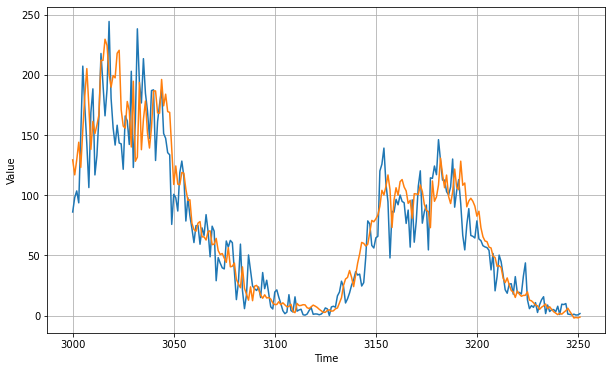

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.20062